In [1]:
from mylib.statistic_test import *

code_id = "0881 - Maze 1m Results"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0881 - Maze 1m Results is already existed!


# PVC

In [6]:
def _pvc(ratemap1, ratemap2):
    pvc = np.zeros(111)
    for i in range(111):
        b = CP_DSPs[4][0][i]-1
        pvc[i] = np.corrcoef(ratemap1[:, b], ratemap2[:, b])[0, 1]
        
    idx = np.where(np.isnan(pvc) == False)[0]
    pvc[idx] = np.convolve(pvc[idx], np.ones(5)/5, mode='same')
        
    return pvc

def calc_pvc(trace):
    if 'node 15' in trace.keys():
        pvc = np.zeros((13, 111))
        routes = np.array([1, 2, 3, 7, 0, 4, 5, 6, 0, 8, 9, 10, 0])
        
        for i in range(1, 6):
            pvc[i-1, :] = _pvc(trace['node 0']['old_map_clear'], trace[f'node {i}']['old_map_clear'])

        for i in range(7, 11):
            pvc[i-2, :] = _pvc(trace['node 6']['old_map_clear'], trace[f'node {i}']['old_map_clear'])
        
        for i in range(12, 16):
            pvc[i-3, :] = _pvc(trace['node 11']['old_map_clear'], trace[f'node {i}']['old_map_clear'])
            
    else:
        pvc = np.zeros((9, 111))
        routes = np.array([1, 2, 3, 7, 0, 4, 5, 6, 0])
        
        for i in range(1, 6):
            pvc[i-1, :] = _pvc(trace['node 0']['old_map_clear'], trace[f'node {i}']['old_map_clear'])
        
        for i in range(7, 11):
            pvc[i-2, :] = _pvc(trace['node 6']['old_map_clear'], trace[f'node {i}']['old_map_clear'])
            
    return pvc, routes

if exists(join(figdata, f"{code_id} [PVC].pkl")) == False:
    PVCData = {
        "MiceID": [],
        "Session": [],
        "Bin": [],
        "PVC": [],
        "Route": []
    }
    
    for mouse in [10266]:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        
        print(f"{mouse}:")
        for s, idx in tqdm(enumerate(file_idx)):
            
            with open(f2['Trace File'][idx], 'rb') as f:
                trace = pickle.load(f)
            pvc, routes = calc_pvc(trace)
            bins = np.tile(np.arange(1, 112), (pvc.shape[0], 1))
            routes = np.tile(routes[:, np.newaxis], (1, pvc.shape[1]))
            mices = np.full(pvc.size, mouse)
            sessions = np.full(pvc.size, s)
            
            PVCData['MiceID'].append(mices.flatten())
            PVCData['Session'].append(sessions.flatten())
            PVCData['PVC'].append(pvc.flatten())
            PVCData['Route'].append(routes.flatten())
            PVCData['Bin'].append(bins.flatten())
            
    for key in PVCData.keys():
        PVCData[key] = np.concatenate(PVCData[key])
        
    with open(join(figdata, f"{code_id} [PVC].pkl"), 'wb') as f:
        pickle.dump(PVCData, f)
        
    PVCD = pd.DataFrame(PVCData)
    PVCD.to_excel(join(figdata, f"{code_id} [PVC].xlsx"), index=False)
    print(len(PVCD))
else:
    with open(join(figdata, f"{code_id} [PVC].pkl"), 'rb') as f:
        PVCData = pickle.load(f)

subdata_0 = SubDict(PVCData, PVCData.keys(), np.where(PVCData['Route'] == 0)[0])
save_loc = join(loc, "PVC")
mkdir(save_loc)
for rt in range(1, 11):    
    subdata = SubDict(PVCData, PVCData.keys(), np.where(np.isin(PVCData['Route'], [rt]))[0])
    fig = plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.lineplot(
        x='Bin', 
        y='PVC', 
        hue='Session',
        data=subdata,
        linewidth=0.5,
        palette="rainbow",
        err_kws={'edgecolor': None},
        legend=False,
        ax=ax
    )
    sns.lineplot(
        x='Bin', 
        y='PVC', 
        hue='Route',
        data=subdata_0,
        linewidth=0.5,
        palette=[DSPPalette[0]],
        err_kws={'edgecolor': None},
        legend=False,
        ax=ax
    )
    ax.set_xlim(0, 112.5)
    ax.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
    ax.set_ylim(-0.1, 0.9)
    ax.set_yticks(np.linspace(-0.1, 0.9, 6))
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.set
    ax.set_title(f"Route {rt+1}")
    plt.savefig(join(save_loc, f"R{rt+1}.png"), dpi=600)
    plt.savefig(join(save_loc, f"R{rt+1}.svg"), dpi=600)
    plt.close()


10266:


0it [00:00, ?it/s]d:\Software\Anaconda3\envs\maze\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\Software\Anaconda3\envs\maze\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
11it [00:57,  5.21s/it]


13209
        D:\Data\FinalResults\Dsp\0881 - Maze 1m Results\PVC is already existed!


# Lapwise Correlation

0it [00:00, ?it/s]d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
d:\Software\Anaconda3\envs\maze\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\Software\Anaconda3\envs\maze\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
0it [00:03, ?it/s]


ValueError: could not broadcast input array from shape (144,144) into shape (114,114)

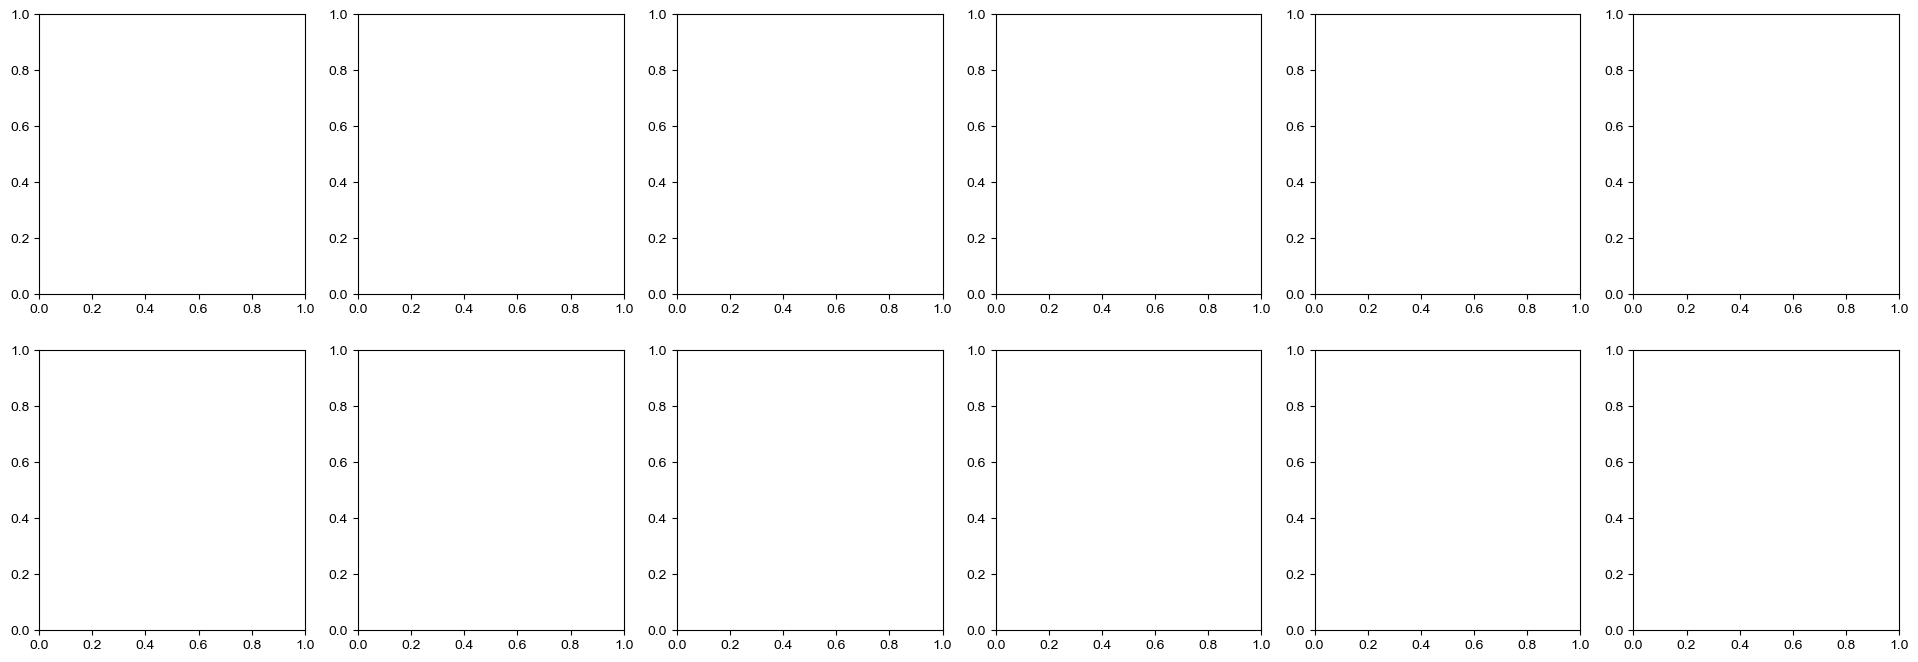

In [ ]:
from mazepy.datastruc.neuact import SpikeTrain
from mazepy.datastruc.variables import VariableBin

def get_lapwise_ratemap(trace: dict, is_cutted: bool = True):    
    maze_type = trace['maze_type']
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx, maze_type)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    for i in range(beg_idx.shape[0]):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes)
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T

    X = np.transpose(smoothed_map, (2, 1, 0))
    return X

file_idx = np.where(f2['MiceID'] == 10266)[0]
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(4*6, 4*2))
for s, idx in tqdm(enumerate(file_idx)):
    with open(f2['Trace File'][idx], 'rb') as f:
        trace = pickle.load(f)
    
    lap_ratemap = get_lapwise_ratemap(trace, is_cutted=True)
    corr = np.zeros((lap_ratemap.shape[0], lap_ratemap.shape[0], lap_ratemap.shape[2]))
    for n in range(lap_ratemap.shape[2]):
        corr[:, :, n] = np.corrcoef(lap_ratemap[:, :, n])
    corr = np.corrcoef(np.median(corr, axis=2))
    ax: Axes = axes[s//6, s%6]
    ax.imshow(corr, vmin=0, vmax=0.5, cmap='jet')

In [12]:
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
save_loc = join(loc, "Lapwise Map", "Binwise PCA")
mkdir(save_loc)

pos_traj = []
neural_traj = []
route_traj = []
Xs = Xs / (np.max(Xs, axis=1, keepdims=True)+1e-8)

for i in range(Xs.shape[0]):
    rt = route_label[i]
    pos_traj.append(CP_DSPs[4][rt])
    neural_traj.append(Xs[i, CP_DSPs[4][rt]-1, :].T)
    route_traj.append(np.ones(len(CP_DSPs[4][rt]))*rt)

pos_traj = np.concatenate(pos_traj)
neural_traj = np.concatenate(neural_traj, axis=1)
route_traj = np.concatenate(route_traj)


pca = PCA(n_components=30)
denoised_data = pca.fit_transform(neural_traj.T)
umap_m = UMAP(n_components=3, random_state=42, n_neighbors=15)
umap_result = umap_m.fit_transform(denoised_data)


        D:\Data\FinalResults\Dsp\0881 - Maze 1m Results\Lapwise Map\Binwise PCA is already existed!


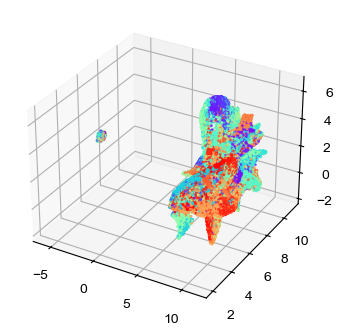

In [13]:
D = GetDMatrices(4, 48)
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(111, projection='3d')
scatter = ax.scatter(
    umap_result[:, 0],
    umap_result[:, 1],
    umap_result[:, 2],
    c=D[pos_traj-1, 0],
    cmap='rainbow',
    s=1,
    alpha=0.7
)